In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from ensemble.distributions import distribution_dict
from ensemble.ensemble_model import EnsembleFitter, EnsembleModel

# Fitting individual distributions

Optimization terminated successfully.
         Current function value: 15.088468
         Iterations: 18
         Function evaluations: 66
         Gradient evaluations: 22
params from optim:  0.372934352041326 6.535494538174693


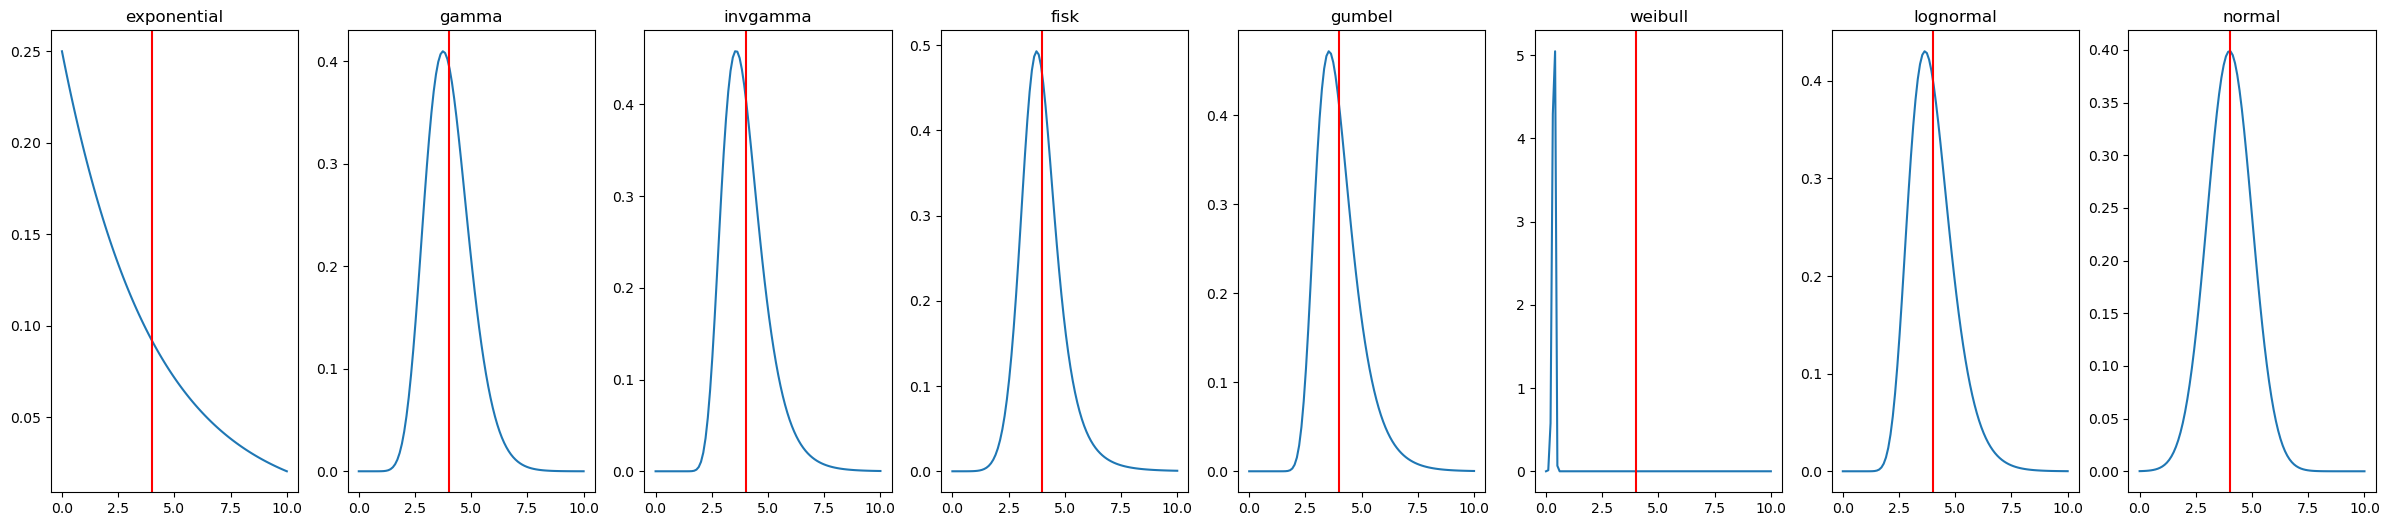

In [2]:
MEAN = 4
VARIANCE = 1
fitted_distributions = {}
counter = 0
fig, ax = plt.subplots(1, len(distribution_dict) - 1, figsize=(30, 6))
for distribution in distribution_dict:
  if distribution != "beta":
    fitted_distributions[distribution] = distribution_dict[distribution](MEAN, VARIANCE)
    # support_01 = np.linspace(0.00000001, 0.999999999, 100)
    # quantiles = fitted_distributions[distribution].ppf(support_01)
    # ax[counter].hist(quantiles)
    support = np.linspace(0, 10, 100)
    pdf = fitted_distributions[distribution].pdf(support)
    ax[counter].plot(support, pdf)
    ax[counter].axvline(MEAN, color="red")
    ax[counter].title.set_text(distribution)
    counter += 1


# Fitting ensemble distributions

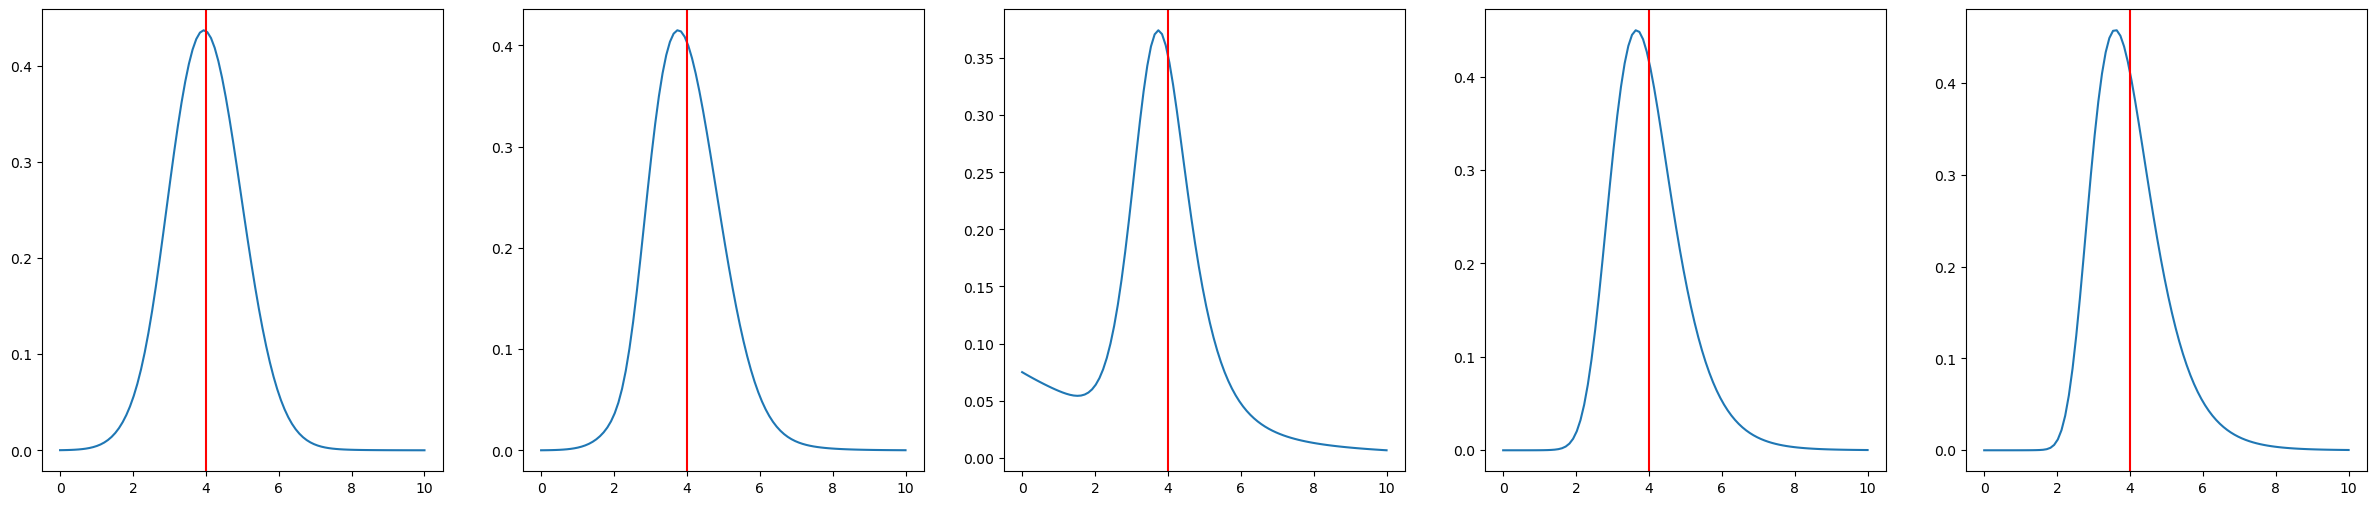

In [3]:
support = np.linspace(0, 10, 100)

def plot_ensembles(distributions, weights, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(distributions), figsize=figsize)
  for i in range(len(distributions)):
    mod = EnsembleModel(distributions[i], weights[i], mean, variance)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].axvline(mean, color="red")

distributions = [["normal", "gumbel"],
                 ["normal", "gumbel"],
                 ["exponential", "fisk"],
                 ["invgamma", "lognormal", "fisk"],
                 ["invgamma", "lognormal", "fisk"]]

weights = [[0.99, 0.1], [0.6, 0.4], [0.3, 0.7], [0.3, 0.5, 0.2], [0.9, 0.05, 0.05]]

plot_ensembles(distributions, weights, MEAN, VARIANCE, support, (30, 6))

# Comparing fitted ensemble distributions to truth

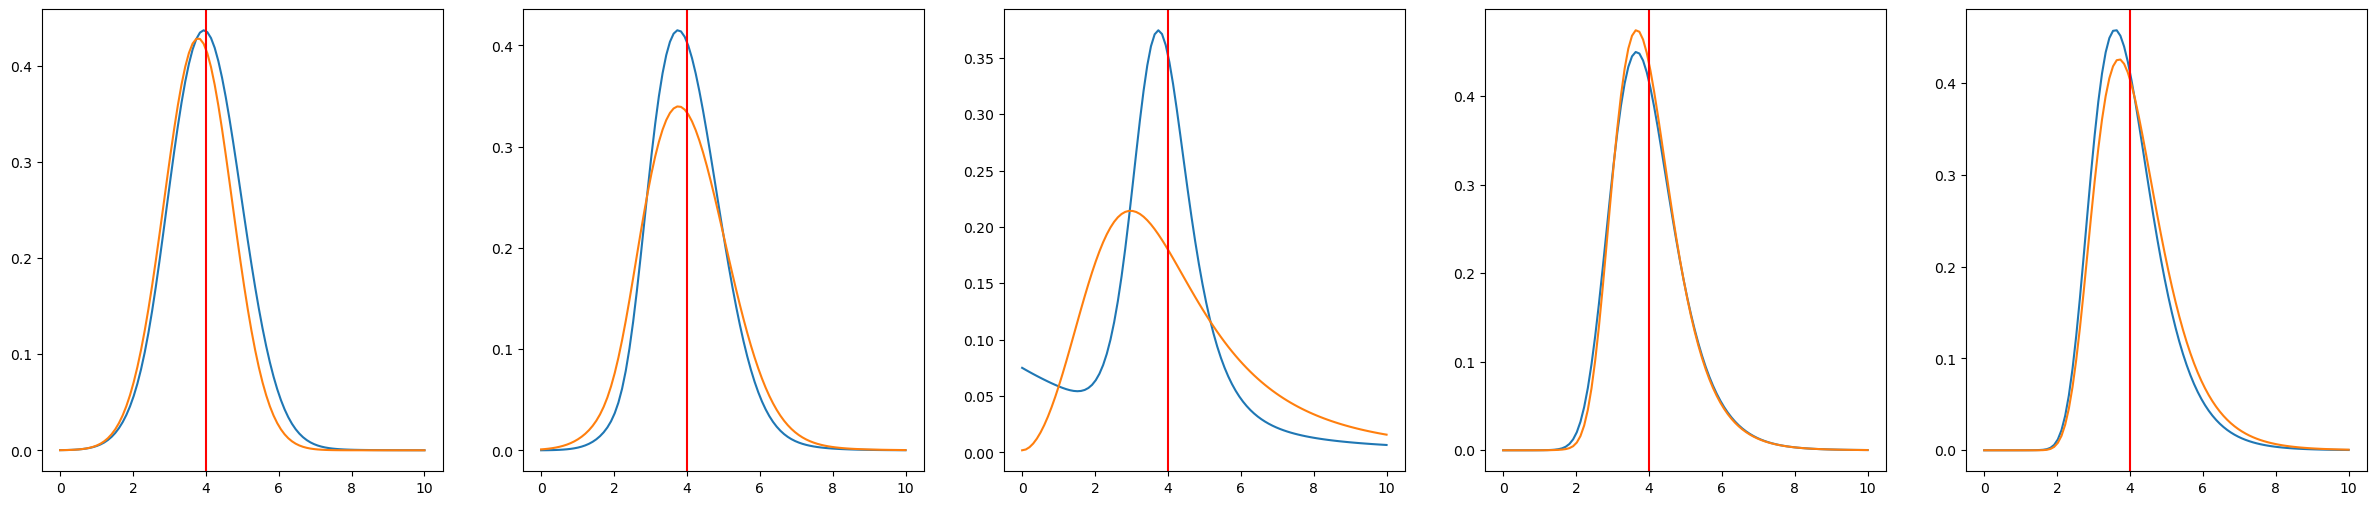

In [4]:
# fig, ax = plt.subplots(1, 5, figsize=(30, 6))
support = np.linspace(0, 10, 100)

def ensemble_comparison(distributions, weights, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(distributions), figsize=figsize)
  for i in range(len(distributions)):
    mod = EnsembleModel(distributions[i], weights[i], mean, variance)
    mod_draws = mod.rvs(size=len(support))
    fit = EnsembleFitter(distributions[i], "L2").fit(mod_draws)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].plot(support, fit.ensemble_model.pdf(support))
    ax[i].axvline(mean, color="red")

distributions = [["normal", "gumbel"],
                 ["normal", "gumbel"],
                 ["exponential", "fisk"],
                 ["invgamma", "lognormal", "fisk"],
                 ["invgamma", "lognormal", "fisk"]]

weights = [[0.99, 0.1], [0.6, 0.4], [0.3, 0.7], [0.3, 0.5, 0.2], [0.9, 0.05, 0.05]]

ensemble_comparison(distributions, weights, MEAN, VARIANCE, support, (30, 6))

# How does Scipy work?

In [5]:
# helper funcs
def reverse_z(z, mean, variance):
  return z * np.sqrt(variance) + mean

(4.0, 1.0)
0.022750131948179195


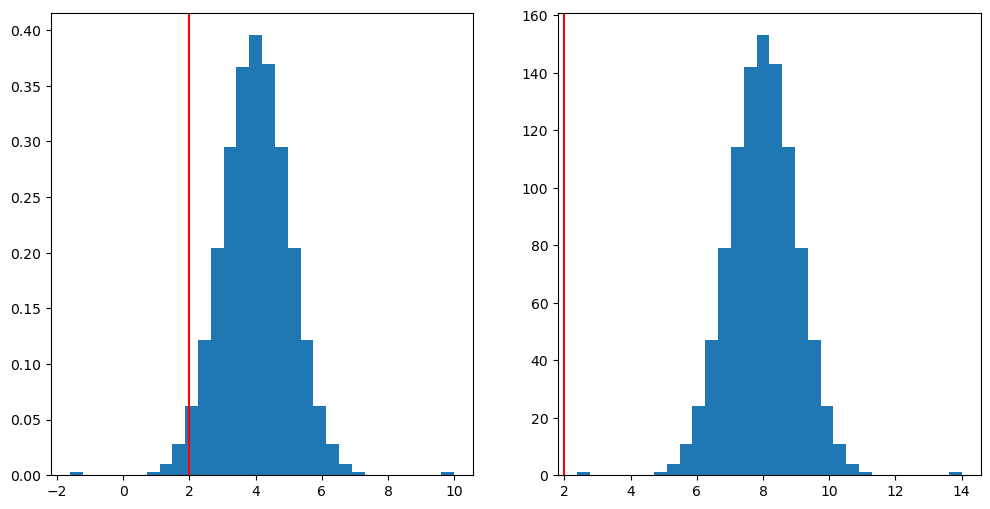

In [6]:
# initialize Normal(0, 1)
MEAN = 4
VARIANCE = 1
std_norm = distribution_dict["normal"](MEAN, VARIANCE)
print(std_norm.stats(moments="mv"))
support_01 = np.linspace(0.00000001, 0.999999999, 1000)
quantiles = std_norm.ppf(support_01)
vals = reverse_z(quantiles, MEAN, VARIANCE)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(quantiles, density=True, bins=30)
quantile = 2
print(std_norm.cdf(quantile))
ax[0].axvline(quantile, color="red")

ax[1].hist(vals, bins=30)
ax[1].axvline(quantile, color="red")
plt.show()





* this shows that cdf and pdf take values from the real line, as if cdf were to take 